In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import gc
import sklearn

cwd = os.getcwd()
print(os.listdir(cwd + '\\input'))
print(cwd)

folder_path = cwd + '\\input\\' 
os.chdir(folder_path)
print(folder_path)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


['train_identity.csv', 'train_transaction.csv']
C:\Users\KV\Desktop
C:\Users\KV\Desktop\input\


In [2]:
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
train_transaction = train_transaction.fillna(0)

df0 = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')


print(train_transaction)


        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400          68.500         W   
1             2987001        0          86401          29.000         W   
2             2987002        0          86469          59.000         W   
3             2987003        0          86499          50.000         W   
4             2987004        0          86506          50.000         H   
5             2987005        0          86510          49.000         W   
6             2987006        0          86522         159.000         W   
7             2987007        0          86529         422.500         W   
8             2987008        0          86535          15.000         H   
9             2987009        0          86536         117.000         W   
10            2987010        0          86549          75.887         C   
11            2987011        0          86555          16.495         C   
12            2987012    

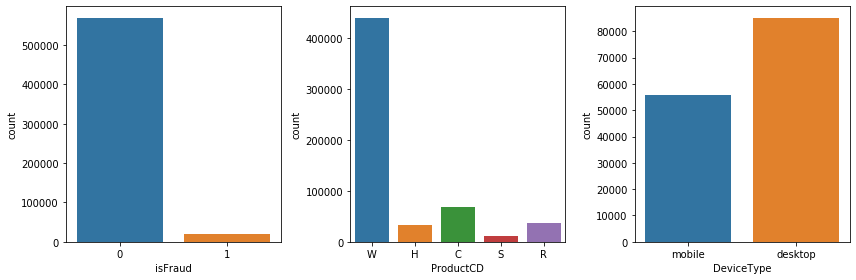

In [3]:
#Plot I: target, ProductCD, Devicetype, DeviceInfo
f, axes = plt.subplots(1, 3, figsize=(12, 4))
isFraud = sns.countplot(x='isFraud', data=df0, ax=axes[0])
ProductCD = sns.countplot(x='ProductCD', data=df0, ax=axes[1])
DeviceType = sns.countplot(x='DeviceType', data=df0, ax=axes[2])
plt.tight_layout()

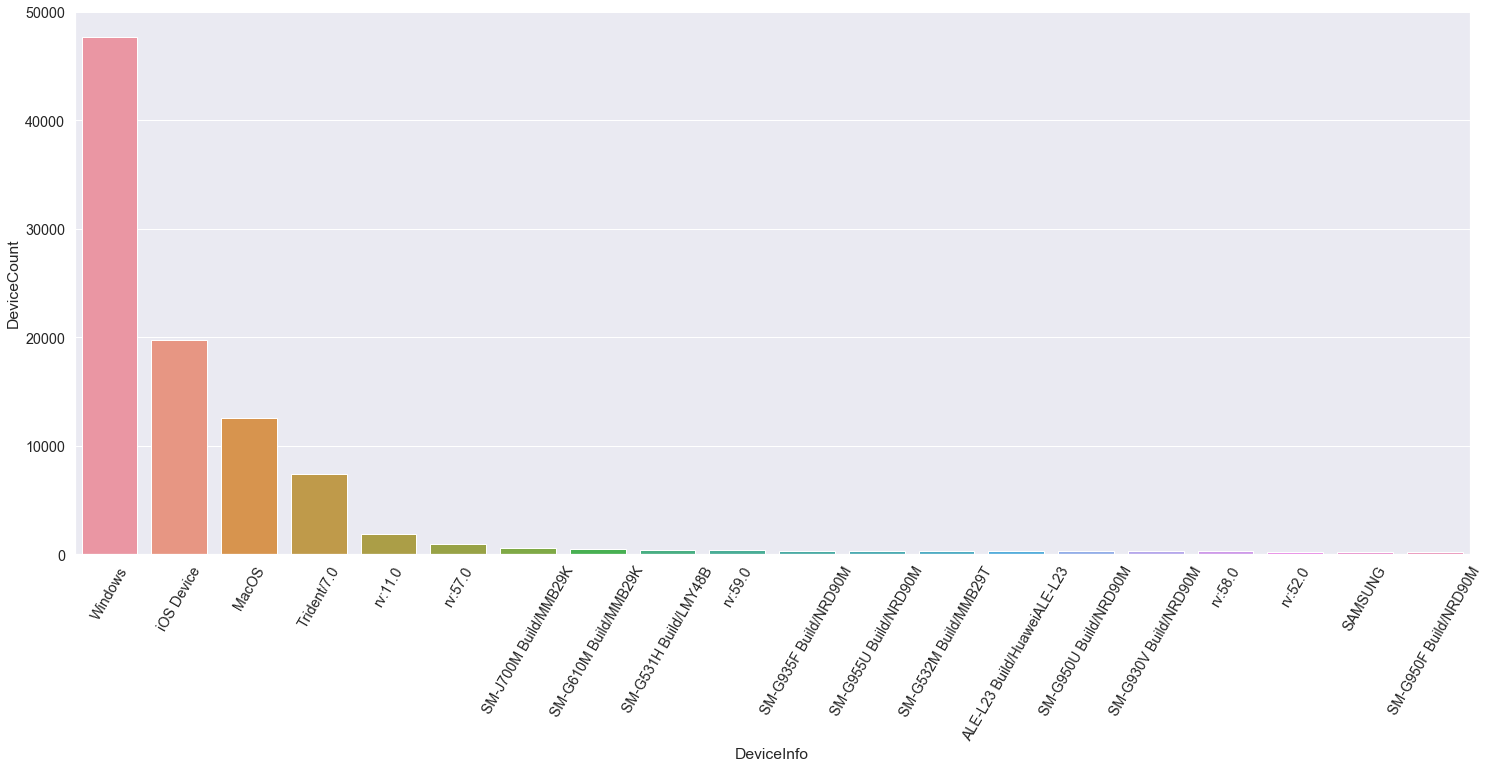

In [4]:
#Plot II: DeviceInfo
group = pd.DataFrame()
group['DeviceCount'] = train_identity.groupby(['DeviceInfo'])['DeviceInfo'].count()
group['DeviceInfo'] = group.index

# There are too many Devices, so we will subset the top 20
group_top = group.sort_values(by='DeviceCount',ascending=False).head(20)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="DeviceInfo", y="DeviceCount", data=group_top)
xt = plt.xticks(rotation=60)

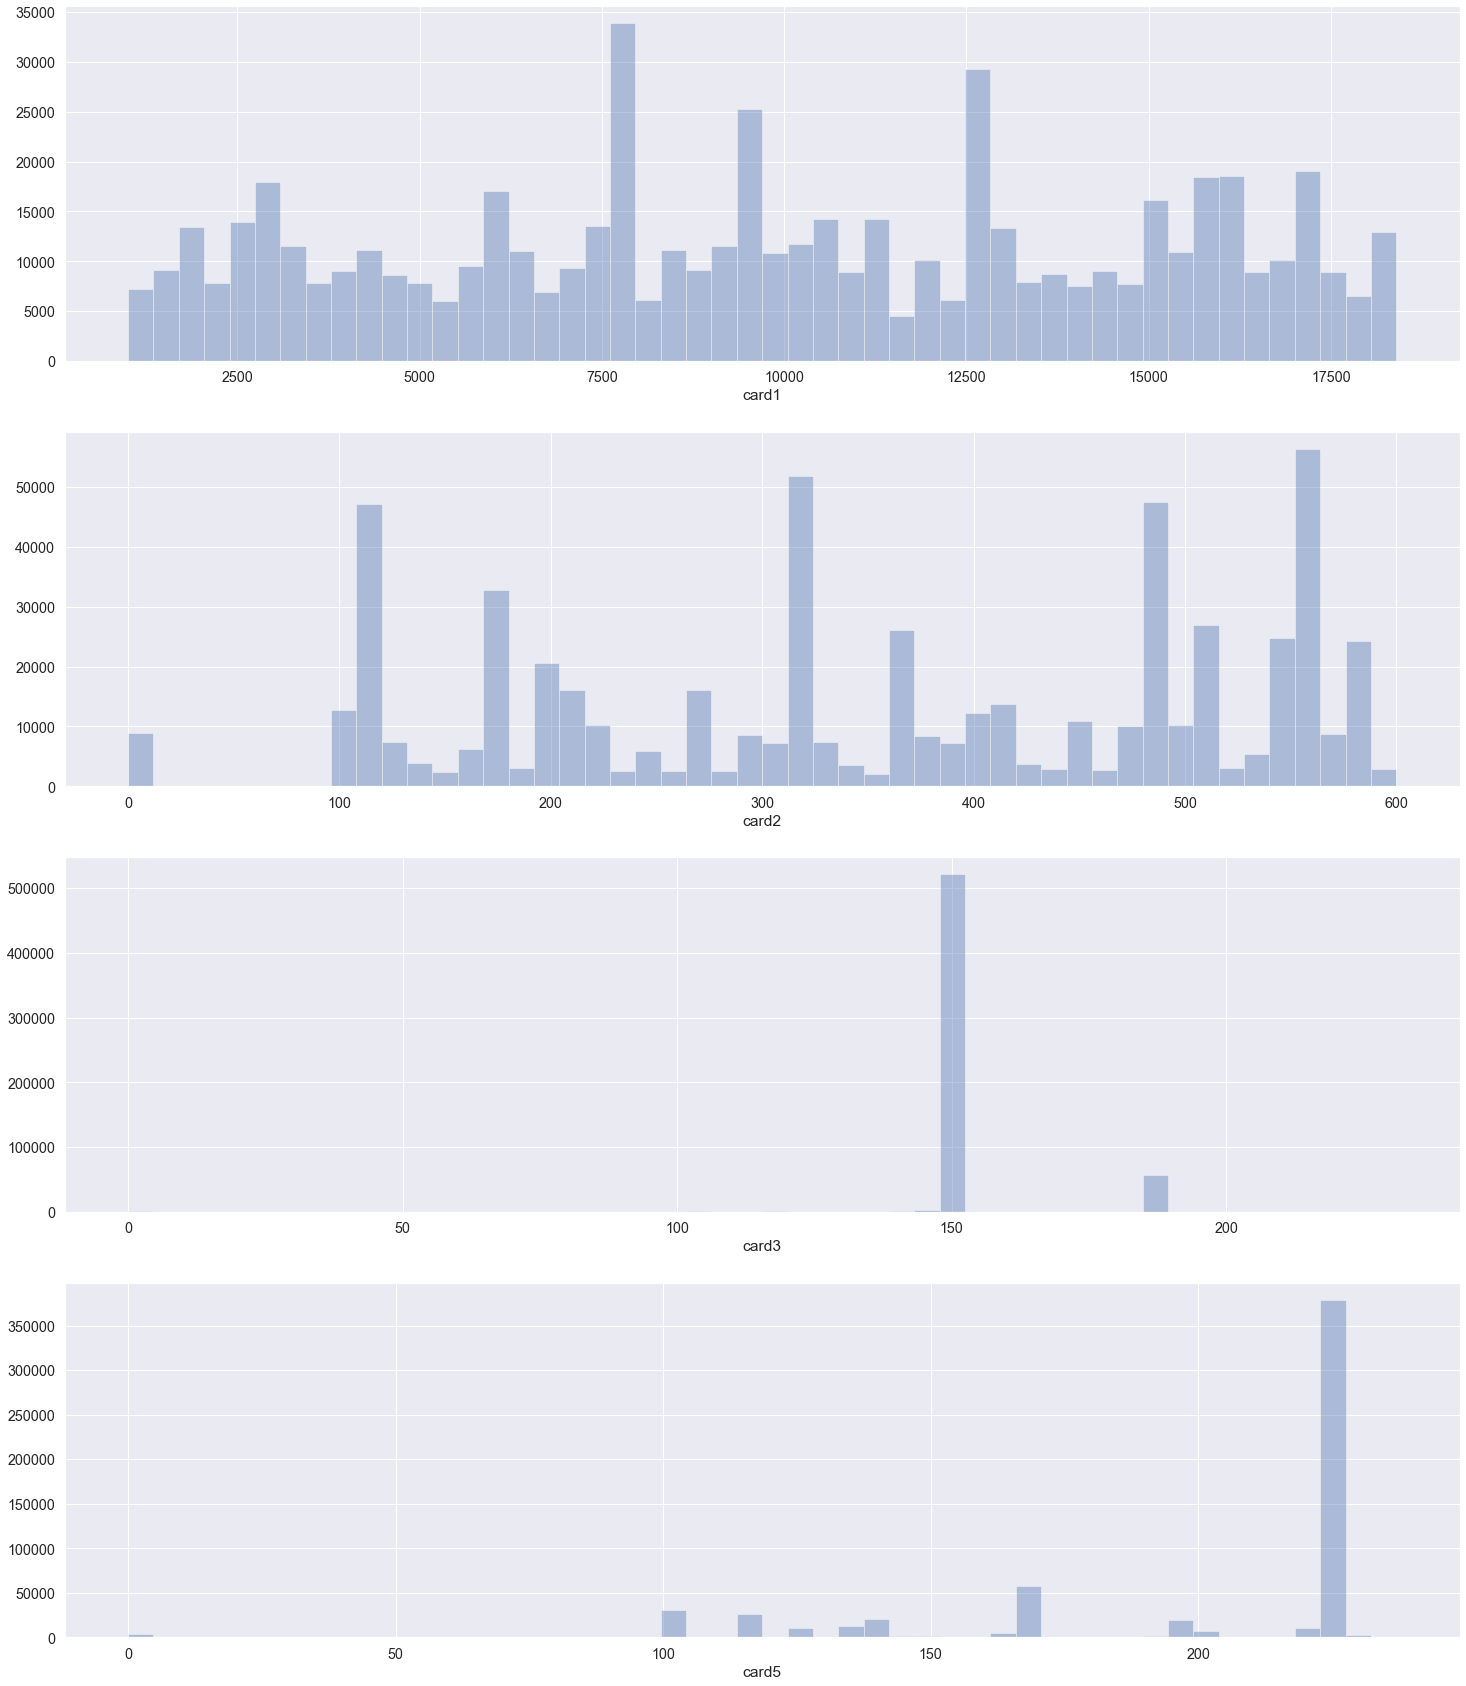

In [5]:
#Plot III: cards 1,2,3, and 5
f, axes = plt.subplots(4, 1, figsize=(25, 30))

c1 = sns.distplot(train_transaction.card1,kde=False, ax=axes[0])
c2 = sns.distplot(train_transaction.card2.dropna(),kde=False, ax=axes[1])
c3 = sns.distplot(train_transaction.card3.dropna(),kde=False, ax=axes[2])
c5 = sns.distplot(train_transaction.card5.dropna(),kde=False, ax=axes[3])

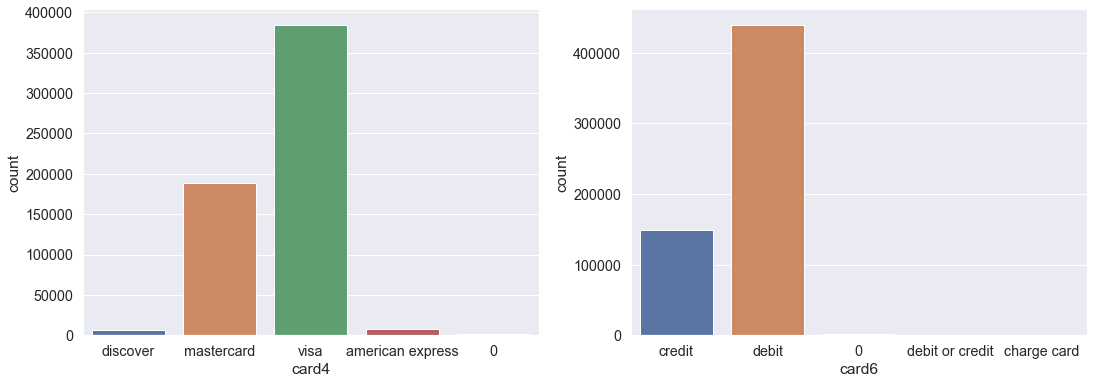

In [6]:
# Plot IV: cards 4 and 6
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set(color_codes=True)
card4 = sns.countplot(x='card4', data=train_transaction, ax=axes[0])
card6 = sns.countplot(x='card6', data=train_transaction, ax=axes[1])

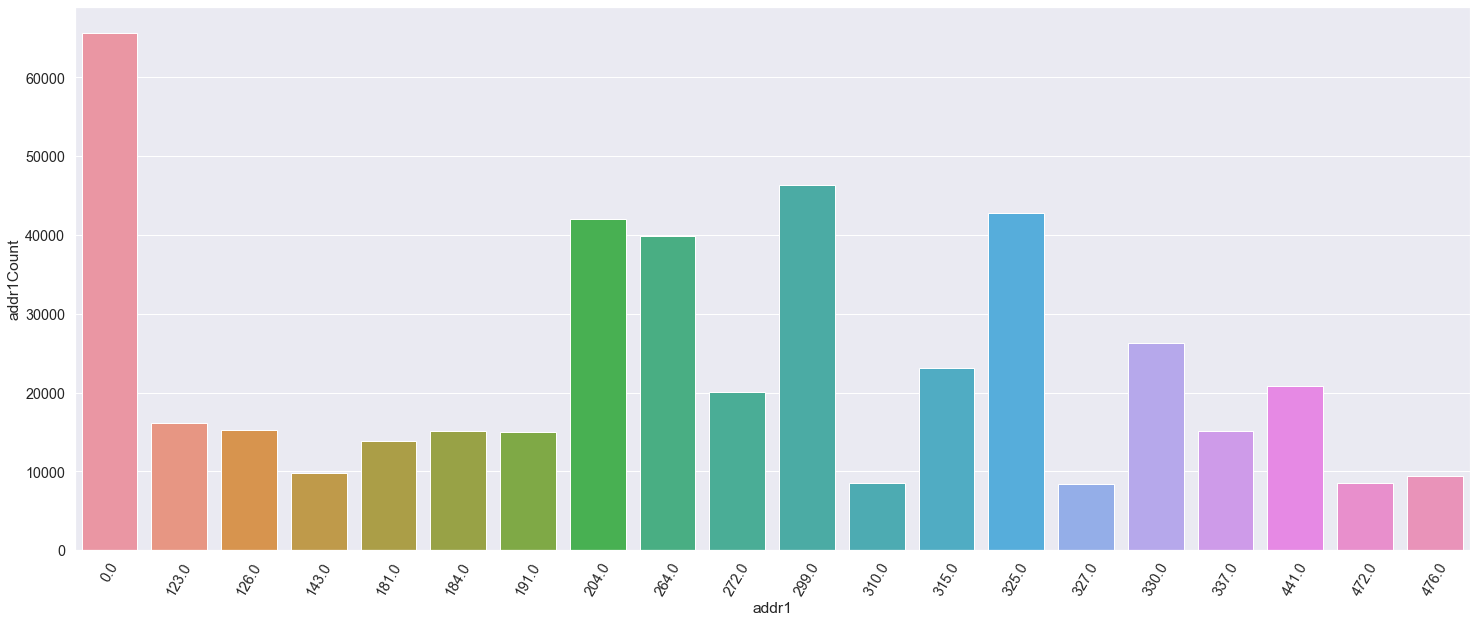

In [7]:
#Plot V: addr1
group = pd.DataFrame()
group['addr1Count'] = train_transaction.groupby(['addr1'])['addr1'].count()
group['addr1'] = group.index

# There are too many addr, so we will subset the top 20
group_top = group.sort_values(by='addr1Count',ascending=False).head(20)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="addr1", y="addr1Count", data=group_top)
xt = plt.xticks(rotation=60)

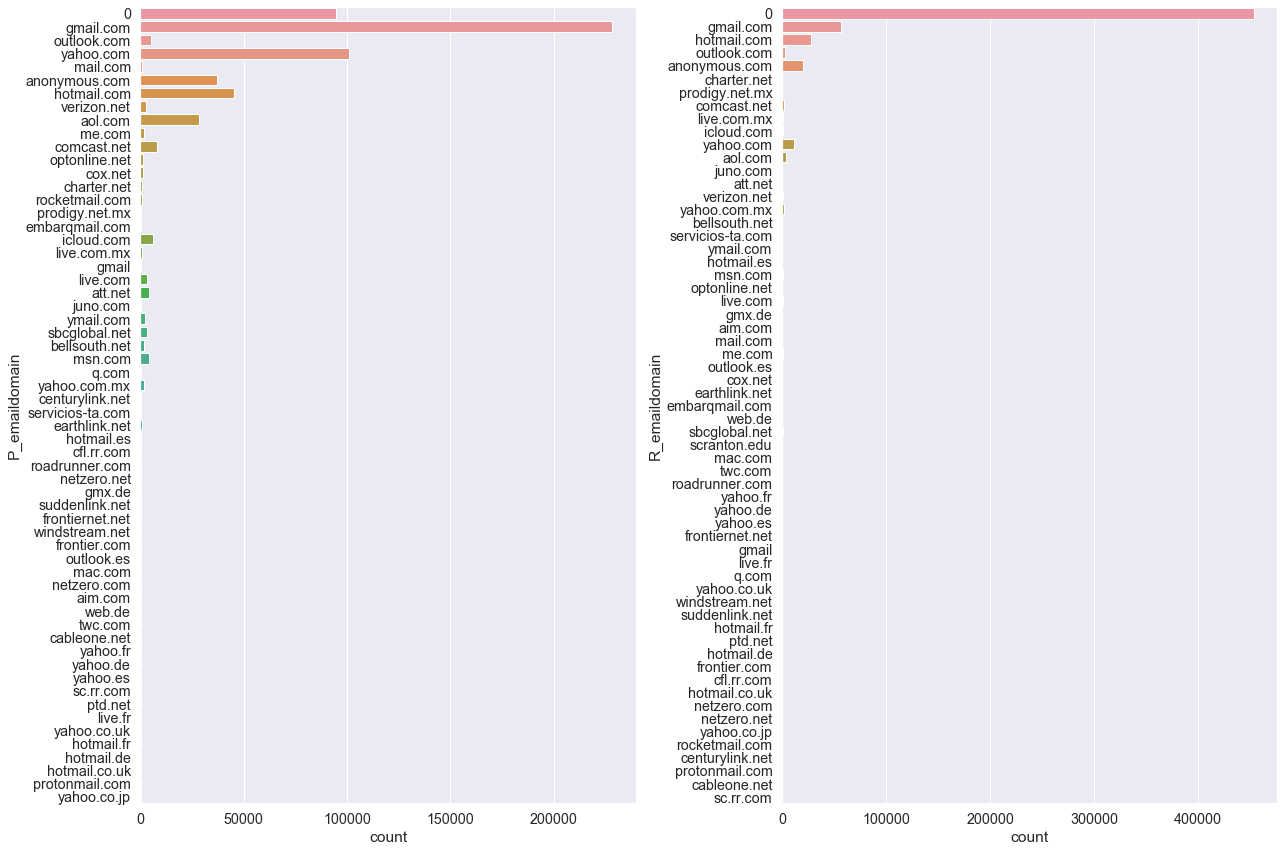

In [8]:
#Plot VII: emaildomains
f, axes = plt.subplots(1, 2, figsize=(18, 12))

sns.set(color_codes=True)
p_email = sns.countplot(y='P_emaildomain', data=train_transaction, ax=axes[0])
r_email = sns.countplot(y='R_emaildomain', data=train_transaction, ax=axes[1])
plt.tight_layout()


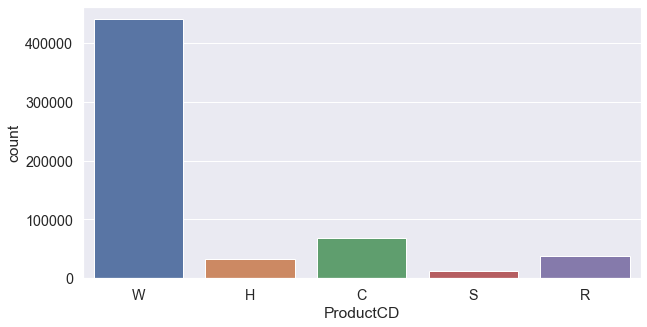

In [9]:
# Plot XI: ProductCD
plt.figure(figsize=(10, 5))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.countplot(x='ProductCD', data=train_transaction)

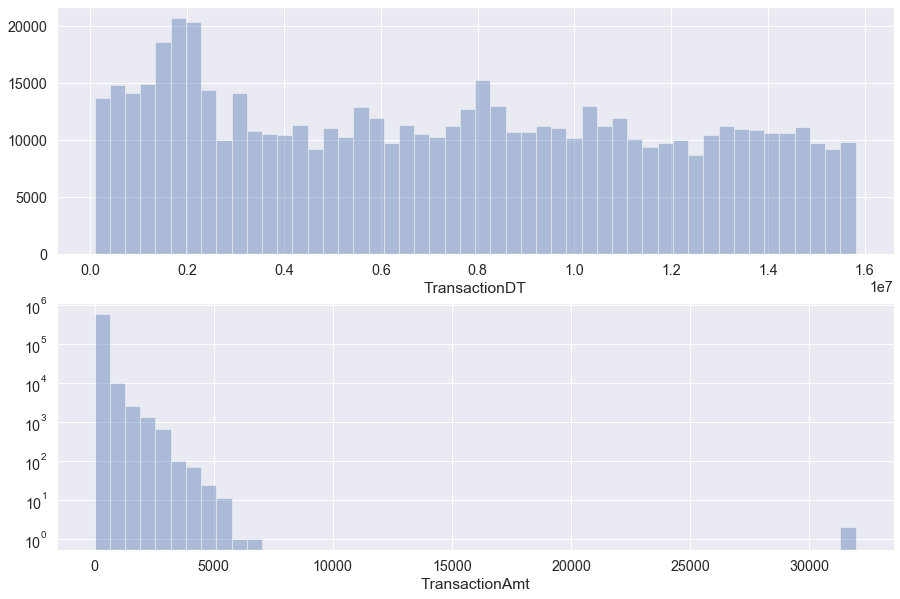

In [10]:
# Plot XII: TransactionDT, TransactionAmt
f, axes = plt.subplots(2, 1, figsize=(15, 10))

dt = sns.distplot(train_transaction.TransactionDT,kde=False, ax=axes[0])
am = sns.distplot(train_transaction.TransactionAmt,kde=False, hist_kws={'log':True}, ax=axes[1])

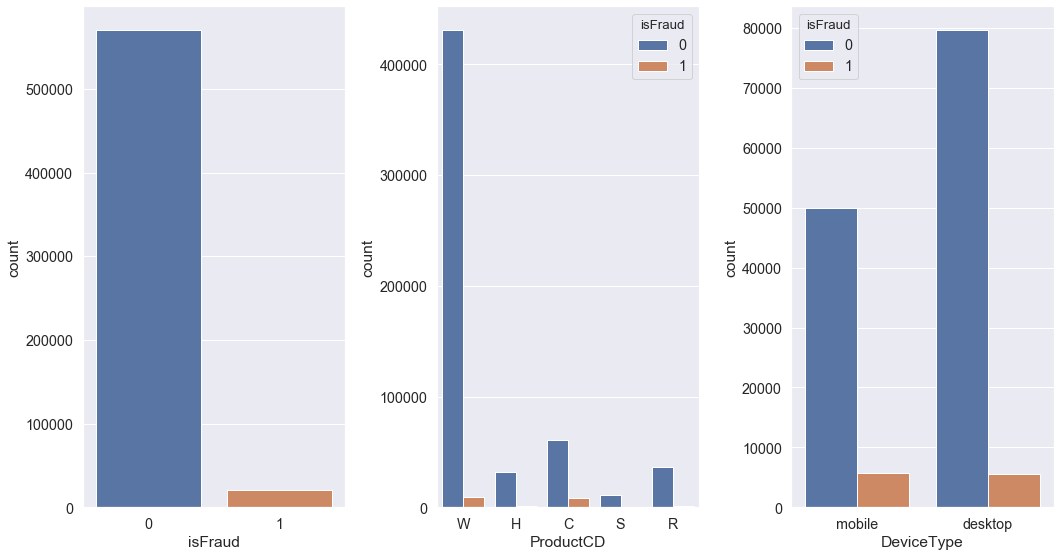

In [11]:
#Plot I: target, ProductCD, Devicetype, DeviceInfo / Target
f, axes = plt.subplots(1, 3, figsize=(15, 8))
isFraud = sns.countplot(x='isFraud', data=df0, ax=axes[0])
ProductCD = sns.countplot(x='ProductCD', hue="isFraud", data=df0, ax=axes[1])
DeviceType = sns.countplot(x='DeviceType', hue="isFraud", data=df0, ax=axes[2])
plt.tight_layout()

In [12]:


# Only use the 'TransactionAmt' and 'V1', ..., 'V339' features
#features = ['TransactionAmt'] + ['V%d' % number for number in range(1, 339)]
features = ['TransactionAmt'] +['TransactionDT'] + ['C%d' % number for number in range(1, 14)] + ['D%d' % number for number in range(1, 15)] + ['card%d' % number for number in range(1, 3)] + ['card5'] + ['V%d' % number for number in range(1, 100)]

# The target variable which we would like to predict, is the 'Class' variable
target = 'isFraud'

# Now create an X variable (containing the features) and an y variable (containing only the target variable)
X = train_transaction[features]
y = train_transaction[target]

del train_identity
del df0
del train_transaction
#collect residual garbage
gc.collect()


9545

In [13]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X


In [14]:
# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Normalize the data
    X_train = normalize(X_train)
    X_test = normalize(X_test)

    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.81      0.14      0.24     10331

    accuracy                           0.97    295270
   macro avg       0.89      0.57      0.61    295270
weighted avg       0.96      0.97      0.96    295270

